In [1]:
import pandas as pd
import seaborn as sns
import cv2
import matplotlib.pylab as plt
from moviepy.editor import VideoClip
from moviepy.video.io.bindings import mplfig_to_npimage
import numpy as np
from tqdm.auto import tqdm
from IPython.display import Video
from scipy import signal
from trialexp.process.deeplabcut.utils import merge_marker_likelihood, interpolate_bad_points, lowpass_coords

In [2]:
# fn = 'short_video_recode'
fn = '06-14-23_14-40-49.000_TT002_Rig_3_Side_recode'
videofile_path = '/home/MRC.OX.AC.UK/ndcn1330/ettin/Julien/Data/head-fixed/by_sessions/reaching_go_spout_bar_nov22/TT002-2023-06-14-144112/video/'
analysis_results = videofile_path +f'{fn}DLC_resnet50_side_2_hands_newobjJuly3shuffle1_200000.h5'
df = pd.read_hdf(analysis_results)

In [3]:
df.columns = df.columns.droplevel(level=0)
df

bodyparts     shoulder                              elbow              \
coords               x           y likelihood           x           y   
0           991.621338  595.338806   0.127445  918.294617  663.654541   
1          1002.902039  582.032837   0.071112  918.675171  664.634338   
2           991.756470  594.737549   0.077259  918.891785  664.144958   
3           991.955872  594.887695   0.126959  918.397644  664.288269   
4           991.847595  596.309631   0.096585  918.299744  663.944031   
...                ...         ...        ...         ...         ...   
179994      956.973633  593.197327   0.122980  963.933960  691.228088   
179995      957.105042  593.690369   0.198047  959.050720  692.137939   
179996      956.741272  593.477783   0.192084  958.899231  692.169312   
179997      956.710022  592.642883   0.215794  958.734375  691.945374   
179998      956.585632  592.388306   0.194634  958.788513  691.872681   

bodyparts                  wrist                             MCP II  ...  \
coords    likelihood           x           y likelihood           x  ...   
0           0.503556  847.223755  700.711670   0.969346  768.807861  ...   
1           0.521229  846.968689  700.723328   0.967264  768.723877  ...   
2           0.586142  847.393860  700.864197   0.970357  768.684265  ...   
3           0.536652  847.225342  700.484619   0.972246  768.901184  ...   
4           0.580572  847.443115  700.758545   0.972626  768.779419  ...   
...              ...         ...         ...        ...         ...  ...   
179994      0.211754  819.267822  721.483459   0.981399  786.388916  ...   
179995      0.202323  819.025208  721.761963   0.982233  786.104675  ...   
179996      0.264599  819.036621  721.683777   0.982465  786.385620  ...   
179997      0.235406  818.280701  721.692993   0.981747  772.877136  ...   
179998      0.264314  818.280579  721.588806   0.981542  773.121887  ...   

bodyparts   nose tip       spout                                eye  \
coords    likelihood           x           y likelihood           x   
0           0.556478  383.540253  600.704834   0.969319  532.055115   
1           0.554423  383.372406  600.562012   0.968242  531.857666   
2           0.576390  383.696503  601.267212   0.974352  532.015442   
3           0.563120  383.146576  600.728638   0.970146  531.975403   
4           0.552160  383.099823  600.338440   0.980006  532.080078   
...              ...         ...         ...        ...         ...   
179994      0.634877  385.434052  598.303284   0.989263  535.615479   
179995      0.630662  385.513519  598.323792   0.989024  535.564758   
179996      0.637718  385.701599  598.329102   0.989571  535.512939   
179997      0.646773  385.726746  598.331421   0.990234  535.455688   
179998      0.631749  385.780334  598.353210   0.989854  535.337402   

bodyparts                                ear                         
coords              y likelihood           x           y likelihood  
0          363.968994   0.186473  810.662659  409.185303   0.994588  
1          363.955688   0.190279  810.597961  409.123322   0.994528  
2          363.864105   0.181403  810.625793  409.111481   0.994521  
3          363.682831   0.183368  810.412292  408.986298   0.994447  
4          363.545959   0.155370  810.637573  409.071716   0.995017  
...               ...        ...         ...         ...        ...  
179994     363.955231   0.131899  797.260925  407.608032   0.586787  
179995     364.106201   0.130924  797.346497  407.574371   0.593060  
179996     364.197723   0.129217  797.363892  407.407959   0.607735  
179997     364.151855   0.130029  797.664551  407.119690   0.667080  
179998     364.065979   0.145813  797.630859  407.112854   0.657087  

[179999 rows x 63 columns]

In [4]:
df_likelihood = df.loc[:,(slice(None), "likelihood")]
df_likelihood.mean()

bodyparts  coords    
shoulder   likelihood    0.301538
elbow      likelihood    0.406322
wrist      likelihood    0.895791
MCP II     likelihood    0.379583
MCP III    likelihood    0.408112
MCP IV     likelihood    0.432008
MCP V      likelihood    0.447501
IP II      likelihood    0.394233
IP III     likelihood    0.423805
IP IV      likelihood    0.446453
IP V       likelihood    0.358868
tip II     likelihood    0.340228
tip III    likelihood    0.596437
tip IV     likelihood    0.542932
tip V      likelihood    0.470448
jaw        likelihood    0.703663
tongue     likelihood    0.114425
nose tip   likelihood    0.727157
spout      likelihood    0.899498
eye        likelihood    0.277148
ear        likelihood    0.947401
dtype: float64

In [5]:
dftip = df.loc[:, df.columns.get_level_values(0).isin(['tip II','tip III'])]

dfwrist = df.loc[:, df.columns.get_level_values(0).isin(['wrist'])]
dfwrist.columns = dfwrist.columns.droplevel(0)

In [6]:
dftip = merge_marker_likelihood(dftip)

In [7]:
# dftip.loc[dfwrist['wrist','likelihood']<0.8,:] = None
dfwrist = interpolate_bad_points(dfwrist,0.7)
dftip = interpolate_bad_points(dftip,0.7)

In [8]:
dftipmean_smooth = lowpass_coords(dftip, 100, 20)
dfwristmean_smooth = lowpass_coords(dfwrist, 100, 20)

## Plot coordinate with video

In [9]:
videofile_path = '/home/MRC.OX.AC.UK/ndcn1330/ettin/Julien/Data/head-fixed/by_sessions/reaching_go_spout_bar_nov22/TT002-2023-06-14-144112/video/'
videofile = videofile_path +f'{fn}.mp4'

In [10]:
video = cv2.VideoCapture(videofile)

Moviepy - Building video test_100.mp4.
Moviepy - Writing video test_100.mp4



Moviepy - Done !
Moviepy - video ready test_100.mp4


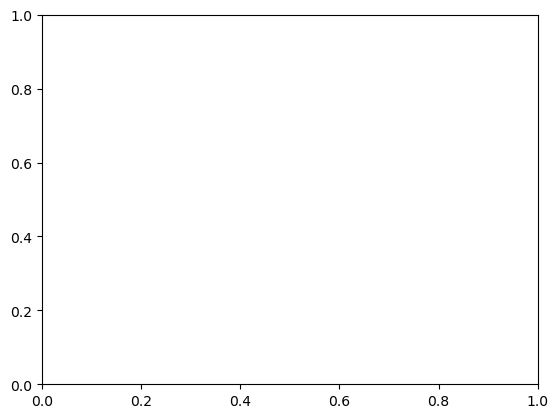

In [13]:
video = cv2.VideoCapture(videofile)
fig, ax = plt.subplots()
frame_no = 0
fps = 100
def make_frame(t):
    frame_no = int(t*fps)
    success, image = video.read()
    df_frame_wrist = dfwristmean_smooth.iloc[frame_no]
    df_frame_tip = dftipmean_smooth.iloc[frame_no]

    # this is much faster than using matplotlib
    image = cv2.circle(image, (int(df_frame_wrist.x), int(df_frame_wrist.y)), radius=10, color=(0, 0, 255), thickness=-1)
    image = cv2.circle(image, (int(df_frame_tip.x), int(df_frame_tip.y)), radius=10, color=(255, 0, 0), thickness=-1)

    return image


duration = np.floor(len(dftipmean_smooth)/fps).astype(int)
animation = VideoClip(make_frame, duration=180*100/fps)
# animation = VideoClip(make_frame, duration=duration)

animation.write_videofile(f'test_{fps}.mp4', fps=fps)
Video('test.mp4')
# animation.ipython_display(fps=30, loop=True, autoplay=True)

In [12]:
dftipmean_smooth.to_pickle('dftip.pkl')
dfwristmean_smooth.to_pickle('dfwrist.pkl')